# LSTM recipe generator training

Note: This notebook is designed to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the recipe dataset.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [1]:
pip install -qU git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12

Import modules and set random seeds.

In [2]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [4]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print(f'Vocabulary size: {VOCAB_SIZE}')

Vocabulary size: 30522


Download the recipe dataset and extract directions texts.

In [6]:
from datasets import load_dataset
recipe = load_dataset('Shengtao/recipe')

def join_title_and_directions(title_directions):
    title, directions = title_directions
    return f'Recipe for {title}: {directions}'

recipe_texts = zip(recipe['train']['title'], recipe['train']['directions'])
recipe_texts = [*map(join_title_and_directions, recipe_texts)]
recipe_texts = recipe_texts[::4] # Select 25% of the entire training set.

In [ ]:
recipe_texts[0]

'Recipe for Simple Macaroni and Cheese: Bring a large pot of lightly salted water to a boil. Cook elbow macaroni in the boiling water, stirring occasionally until cooked through but firm to the bite, 8 minutes. Drain. Melt butter in a saucepan over medium heat; stir in flour, salt, and pepper until smooth, about 5 minutes. Slowly pour milk into butter-flour mixture while continuously stirring until mixture is smooth and bubbling, about 5 minutes. Add Cheddar cheese to milk mixture and stir until cheese is melted, 2 to 4 minutes. Fold macaroni into cheese sauce until coated.'

Check the distribuion of the token length.

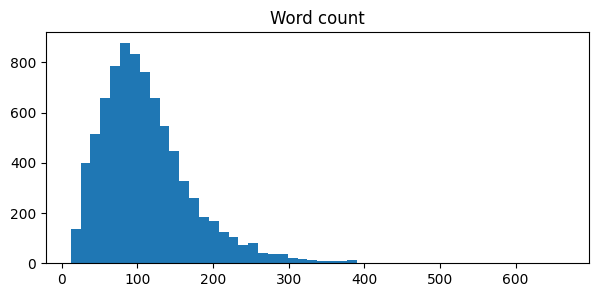

In [ ]:
fig = plt.figure(figsize=(7, 3))
subplot = fig.add_subplot(1,1,1)
subplot.set_title('Word count')

_ = subplot.hist([*map(lambda x: len(x.split(' ')), recipe_texts)], bins=50)

Create the training and test datasets, truncating long texts into 128 words.

In [ ]:
MAX_LEN = 128
train_set, test_set = train_test_split(recipe_texts, test_size=0.1)

train_set = tokenizer(train_set, max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])[:, :-1]
train_label = np.array(train_set['input_ids'])[:, 1:]

test_set = tokenizer(test_set, max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])[:, :-1]
test_label = np.array(test_set['input_ids'])[:, 1:]

Define the LSTM model.

In [ ]:
lstm_model = models.Sequential(name='LSTM_next_word_predictor')
lstm_model.add(layers.Input(shape=(None,), name='input_ids'))
lstm_model.add(layers.Embedding(VOCAB_SIZE, 512, name='text_embedding'))
lstm_model.add(layers.LSTM(512, return_sequences=True, name='LSTM'))
lstm_model.add(layers.Dense(VOCAB_SIZE, activation='softmax', name='softmax'))

lstm_model.summary()

Model: "LSTM_next_word_predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_embedding (Embedding)           │ (None, None, 512)           │      15,627,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM (LSTM)                          │ (None, None, 512)           │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, None, 30522)         │      15,657,786 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,384,250 (127.35 MB)

 Trainable params: 33,384,250 (127.35 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model using the Adam optimizer, and the sparse categorical crossentroy as a loss function.

In [ ]:
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['acc'])

Train the model.

In [ ]:
%%time
history = lstm_model.fit(train_text, train_label,
                         validation_data=(test_text, test_label),
                         batch_size=8, epochs=10)

Epoch 1/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 101s 106ms/step - acc: 0.2398 - loss: 4.9316 - val_acc: 0.5058 - val_loss: 2.6034
Epoch 2/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 141s 107ms/step - acc: 0.5280 - loss: 2.4392 - val_acc: 0.5611 - val_loss: 2.1840
Epoch 3/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 143s 108ms/step - acc: 0.5734 - loss: 2.0739 - val_acc: 0.5811 - val_loss: 2.0352
Epoch 4/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 99s 107ms/step - acc: 0.5948 - loss: 1.9006 - val_acc: 0.5924 - val_loss: 1.9567
Epoch 5/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 143s 108ms/step - acc: 0.6091 - loss: 1.7844 - val_acc: 0.5982 - val_loss: 1.9149
Epoch 6/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 141s 107ms/step - acc: 0.6204 - loss: 1.6950 - val_acc: 0.6024 - val_loss: 1.8911
Epoch 7/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 142s 107ms/step - acc: 0.6306 - loss: 1.6204 - val_acc: 0.6049 - val_loss: 1.8791
Epoch 8/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 142s 107ms/step - acc: 0.6397 - loss: 1.5565 - val_acc: 0.6060 - val_loss: 1.8740
Epoch 9/10
921/921 ━━━━━━

Mount google drive and save the trained model.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

model_file = '/content/gdrive/My Drive/LSTM_recipe_generator.keras'
lstm_model.save(model_file)
!ls -lh '{model_file}'

Mounted at /content/gdrive
-rw------- 1 root root 383M Jan 29 07:55 '/content/gdrive/My Drive/LSTM_recipe_generator.keras'
